In [4]:
import os
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [5]:
data_dir = r"E:\Segmentation\datasets\FloodNet-Supervised_v1.0"
batch_size = 32

In [6]:
print(f"Training data: {len(os.listdir(os.path.join(data_dir, 'train', 'train-org-img')))}")
print(f"Validation data: {len(os.listdir(os.path.join(data_dir, 'val', 'val-org-img')))}")
print(f"Test data: {len(os.listdir(os.path.join(data_dir, 'test', 'test-org-img')))}")

Training data: 1445
Validation data: 450
Test data: 448


In [26]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}
    
color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128], 
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, shift_limit=0.1, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Blur(p=0.3),
    A.HueSaturationValue(p=0.3)
], additional_targets={'mask': 'mask'})

def apply_augmentation(image, mask):
    augmented = augmentation_pipeline(image=image, mask=mask)
    return augmented['image'], augmented['mask']

In [33]:
def to_RGB(label):
    label_seg = np.zeros((*label.shape, 3), dtype=np.uint8)  # Create a 3-channel RGB array
    for key, val in class_map.items():
        # Find where the mask is equal to the current class value
        label_seg[label == val] = color_map[key]
    return label_seg


def display_images_with_masks(image, mask):
    print("Image shape:", image.shape)
    print("Mask shape:", to_RGB(mask).shape)

    plt.figure(figsize=(16, 14))
    
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)

    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(mask))

    plt.legend(handles, labels, bbox_to_anchor=(-0.8, -0.5), loc='lower center', ncol=5)
    plt.show()

Image shape: (3000, 4000, 3)
Mask shape: (3000, 4000, 3)


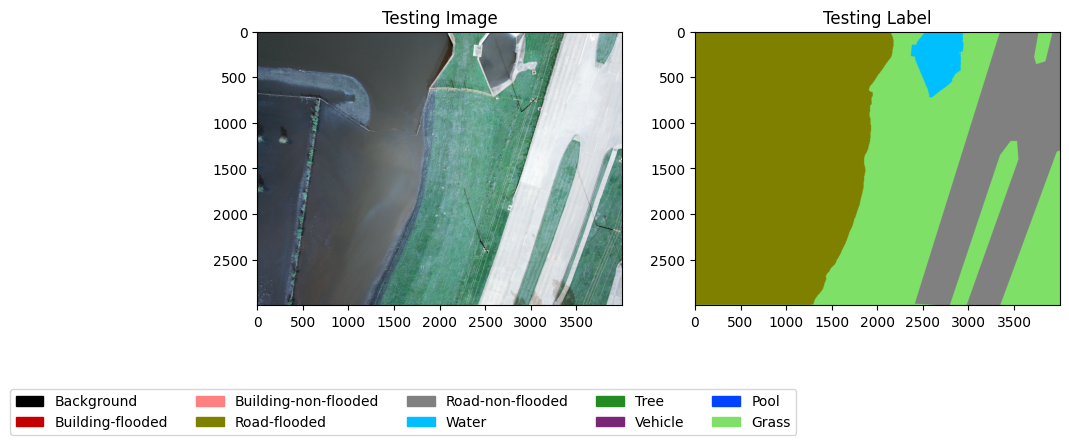

Image shape: (3000, 4000, 3)
Mask shape: (3000, 4000, 3)


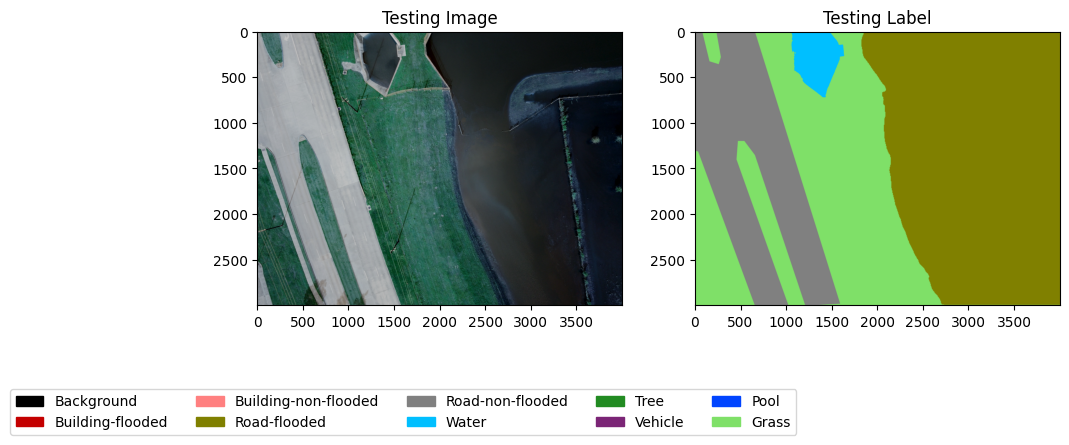

In [36]:
# Sample Usage
image = cv2.imread(f'{data_dir}/train/train-org-img/8206.jpg')
mask = cv2.imread(f'{data_dir}/train/train-label-img/8206.png', cv2.IMREAD_GRAYSCALE)

display_images_with_masks(image, mask)

augmented_image, augmented_mask = apply_augmentation(image, mask)
display_images_with_masks(augmented_image, augmented_mask)

In [43]:
def calculate_label_distribution(image_path):
    import numpy as np
    from imageio import imread
    
    # Load the segmentation labels image
    labels_image = imread(image_path)
    
    # Calculate frequencies of each label
    unique_labels, counts = np.unique(labels_image, return_counts=True)
    distribution = counts / labels_image.size
    
    # Mapping label IDs to their corresponding class names
    label_names = {0: 'Background', 1: 'Building-flooded', 2: 'Building-non-flooded', 
                   3: 'Road-flooded', 4: 'Road-non-flooded', 5: 'Water', 6: 'Tree', 
                   7: 'Vehicle', 8: 'Pool', 9: 'Grass'}
                   
    # Create a dictionary with class names and their distribution
    label_distribution = {label_names.get(label, f'Unknown Label {label}'): dist 
                          for label, dist in zip(unique_labels, distribution)}
    
    return label_distribution

# Usage example, you need to replace '{data_dir}' with the actual directory path
distribution = calculate_label_distribution(f'{data_dir}/train/train-label-img/8206.png')
for key, value in distribution.items():
    print(f"{key:20} : {value:.2f}")

Road-flooded         : 0.45
Road-non-flooded     : 0.20
Water                : 0.02
Grass                : 0.32


In [42]:
distribution = calculate_label_distribution(f'{data_dir}/train/train-label-img/7304.png')

for key, value in distribution.items():
    print(f"{key:20} : {value:.2f}")

Background           : 0.31
Building-non-flooded : 0.26
Road-flooded         : 0.20
Tree                 : 0.22
Vehicle              : 0.01
Pool                 : 0.01


In [44]:
distribution = calculate_label_distribution(f'{data_dir}/train/train-label-img/9459.png')

for key, value in distribution.items():
    print(f"{key:20} : {value:.2f}")

Building-non-flooded : 0.14
Road-non-flooded     : 0.12
Water                : 0.55
Tree                 : 0.05
Vehicle              : 0.00
Grass                : 0.14


In [48]:
import numpy as np
import os
from imageio import imread
from tqdm import tqdm

def calculate_label_distribution(base_dir, subset):
    """
    Calculate label distribution for a given subset (train, test, val) within a dataset.

    Args:
    base_dir (str): The base directory of the dataset.
    subset (str): The subset of the dataset to analyze ('train', 'test', or 'val').

    Returns:
    dict: A dictionary of label names and their distribution percentages.
    """
    label_names = {
        0: 'Background', 1: 'Building-flooded', 2: 'Building-non-flooded',
        3: 'Road-flooded', 4: 'Road-non-flooded', 5: 'Water', 6: 'Tree',
        7: 'Vehicle', 8: 'Pool', 9: 'Grass'
    }
    
    masks_dir = os.path.join(base_dir, subset, f'{subset}-label-img')
    total_counts = {name: 0 for name in label_names.values()}
    total_pixels = 0
    
    # Process each mask file in the directory
    for filename in tqdm(os.listdir(masks_dir)):
        if filename.endswith('.png'):
            filepath = os.path.join(masks_dir, filename)
            mask = imread(filepath)
            
            # Count unique labels in the mask
            unique_labels, counts = np.unique(mask, return_counts=True)
            total_pixels += mask.size
            
            # Accumulate counts for each label
            for label, count in zip(unique_labels, counts):
                if label in label_names:
                    total_counts[label_names[label]] += count

    # Calculate the distribution percentage for each label
    label_distribution = {label: count / total_pixels for label, count in total_counts.items() if count > 0}
    
    return label_distribution

In [49]:
# Usage example
train_distribution = calculate_label_distribution(data_dir, 'train')
test_distribution = calculate_label_distribution(data_dir, 'test')
val_distribution = calculate_label_distribution(data_dir, 'val')

print("Training Set Distribution:", train_distribution)
print("Testing Set Distribution:", test_distribution)
print("Validation Set Distribution:", val_distribution)

100%|██████████| 450/450 [02:15<00:00,  3.33it/s]

Training Set Distribution: {'Background': 0.017353521070257727, 'Building-flooded': 0.01789645956527977, 'Building-non-flooded': 0.03217060473684016, 'Road-flooded': 0.03142128956922194, 'Road-non-flooded': 0.05429983518392128, 'Water': 0.1112056807017939, 'Tree': 0.17463418423700694, 'Vehicle': 0.0018331323320195832, 'Pool': 0.002078820776164229, 'Grass': 0.5571064718274945}
Testing Set Distribution: {'Background': 0.021432743205094897, 'Building-flooded': 0.018681918424163863, 'Building-non-flooded': 0.033918049930960856, 'Road-flooded': 0.025286228890936728, 'Road-non-flooded': 0.05903576681364911, 'Water': 0.10913602038912676, 'Tree': 0.1784225237910488, 'Vehicle': 0.001652698125042228, 'Pool': 0.0019198144951784047, 'Grass': 0.5505142359347983}
Validation Set Distribution: {'Background': 0.02283828039411337, 'Building-flooded': 0.01988776914353768, 'Building-non-flooded': 0.0283372490687492, 'Road-flooded': 0.028411347075281798, 'Road-non-flooded': 0.05790587456356271, 'Water': 0.

In [50]:
print("Training Set Distribution:")
for key, value in train_distribution.items():
    print(f"{key:20} : {value:.2f}")

print("\nTesting Set Distribution:")
for key, value in test_distribution.items():
    print(f"{key:20} : {value:.2f}")

print("\nValidation Set Distribution:")
for key, value in val_distribution.items():
    print(f"{key:20} : {value:.2f}")

Training Set Distribution:
Background           : 0.02
Building-flooded     : 0.02
Building-non-flooded : 0.03
Road-flooded         : 0.03
Road-non-flooded     : 0.05
Water                : 0.11
Tree                 : 0.17
Vehicle              : 0.00
Pool                 : 0.00
Grass                : 0.56

Testing Set Distribution:
Background           : 0.02
Building-flooded     : 0.02
Building-non-flooded : 0.03
Road-flooded         : 0.03
Road-non-flooded     : 0.06
Water                : 0.11
Tree                 : 0.18
Vehicle              : 0.00
Pool                 : 0.00
Grass                : 0.55

Validation Set Distribution:
Background           : 0.02
Building-flooded     : 0.02
Building-non-flooded : 0.03
Road-flooded         : 0.03
Road-non-flooded     : 0.06
Water                : 0.11
Tree                 : 0.19
Vehicle              : 0.00
Pool                 : 0.00
Grass                : 0.54


In [63]:
import numpy as np
import os
from imageio import imread
from tqdm import tqdm

def calculate_label_image_count(base_dir, subsets):
    """
    Calculate the number of images each label appears in across specified subsets of a dataset.

    Args:
    base_dir (str): The base directory where the dataset is stored.
    subsets (list): A list of subsets of the dataset to analyze ('train', 'test', 'val').

    Returns:
    dict: A dictionary with class names as keys and the number of images they appear in as values.
    """
    label_names = {
        0: 'Background', 1: 'Building (flooded)', 2: 'Building (non-flooded)',
        3: 'Road (flooded)', 4: 'Road (non-flooded)', 5: 'Water', 6: 'Tree',
        7: 'Vehicle', 8: 'Pool', 9: 'Grass'
    }

    # Initialize dictionary to count image appearances for each label across all subsets
    label_image_count = {name: 0 for name in label_names.values()}

    # Process each subset and count labels
    for subset in subsets:
        masks_dir = os.path.join(base_dir, subset, f'{subset}-label-img')
        
        # Track labels found in each image to avoid double counting for the same image
        for filename in tqdm(os.listdir(masks_dir)):
            if filename.endswith('.png'):
                filepath = os.path.join(masks_dir, filename)
                mask = imread(filepath)
                unique_labels = np.unique(mask)

                # Update image count for each unique label found in this mask
                for label in unique_labels:
                    if label in label_names:
                        label_image_count[label_names[label]] += 1

    return label_image_count

# Example usage
subsets = ['train', 'test', 'val']  
image_count_across_dataset = calculate_label_image_count(data_dir, subsets)
print(image_count_across_dataset)

  0%|          | 0/1445 [00:00<?, ?it/s]

100%|██████████| 450/450 [01:57<00:00,  3.83it/s]

{'Background': 172, 'Building (flooded)': 245, 'Building (non-flooded)': 880, 'Road (flooded)': 264, 'Road (non-flooded)': 1175, 'Water': 1059, 'Tree': 1882, 'Vehicle': 813, 'Pool': 531, 'Grass': 2161}


In [64]:
for key, value in image_count_across_dataset.items():
    print(f"{key:20} : {value}")

Background           : 172
Building (flooded)   : 245
Building (non-flooded) : 880
Road (flooded)       : 264
Road (non-flooded)   : 1175
Water                : 1059
Tree                 : 1882
Vehicle              : 813
Pool                 : 531
Grass                : 2161


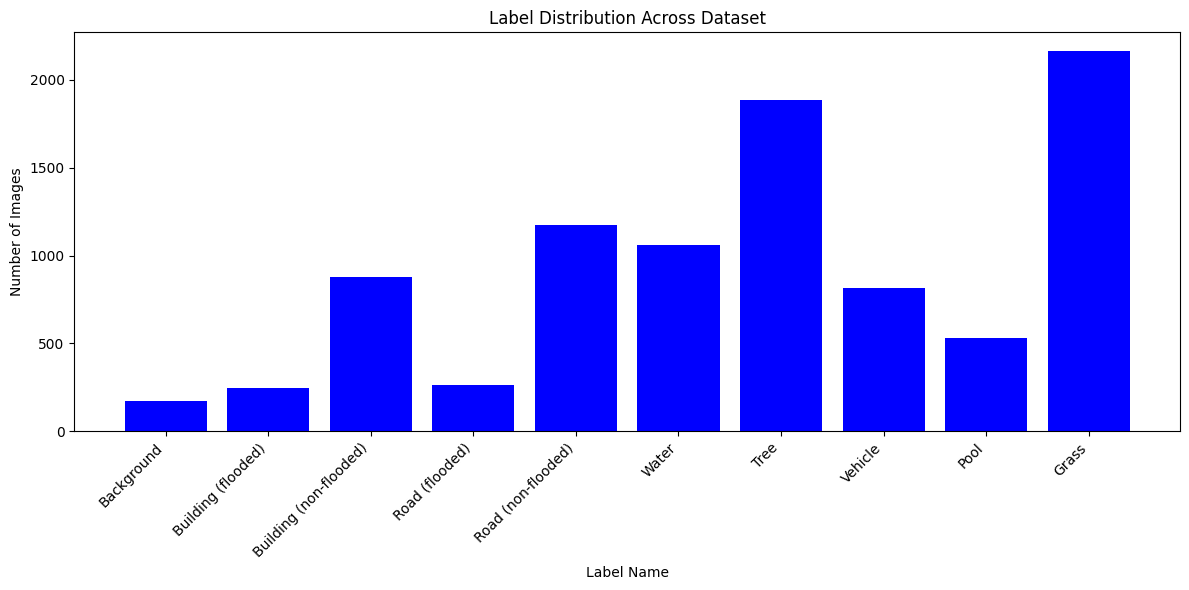

In [66]:
#create a bar graph to show the distribution of the labels across the dataset
import matplotlib.pyplot as plt

def plot_label_distribution(label_counts, title):
    """
    Plot a bar graph showing the distribution of labels across the dataset.

    Args:
    label_counts (dict): A dictionary with class names as keys and their counts as values.
    title (str): The title of the plot.
    """
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color='blue')
    plt.xlabel('Label Name')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot the distribution of labels across the dataset
plot_label_distribution(image_count_across_dataset, 'Label Distribution Across Overall Dataset')

In [67]:
# Example usage
subsets = ['train']  
image_count_across_train_dataset = calculate_label_image_count(data_dir, subsets)
print(image_count_across_train_dataset)

100%|██████████| 1445/1445 [06:08<00:00,  3.92it/s]

{'Background': 98, 'Building (flooded)': 149, 'Building (non-flooded)': 540, 'Road (flooded)': 162, 'Road (non-flooded)': 711, 'Water': 668, 'Tree': 1156, 'Vehicle': 496, 'Pool': 331, 'Grass': 1331}


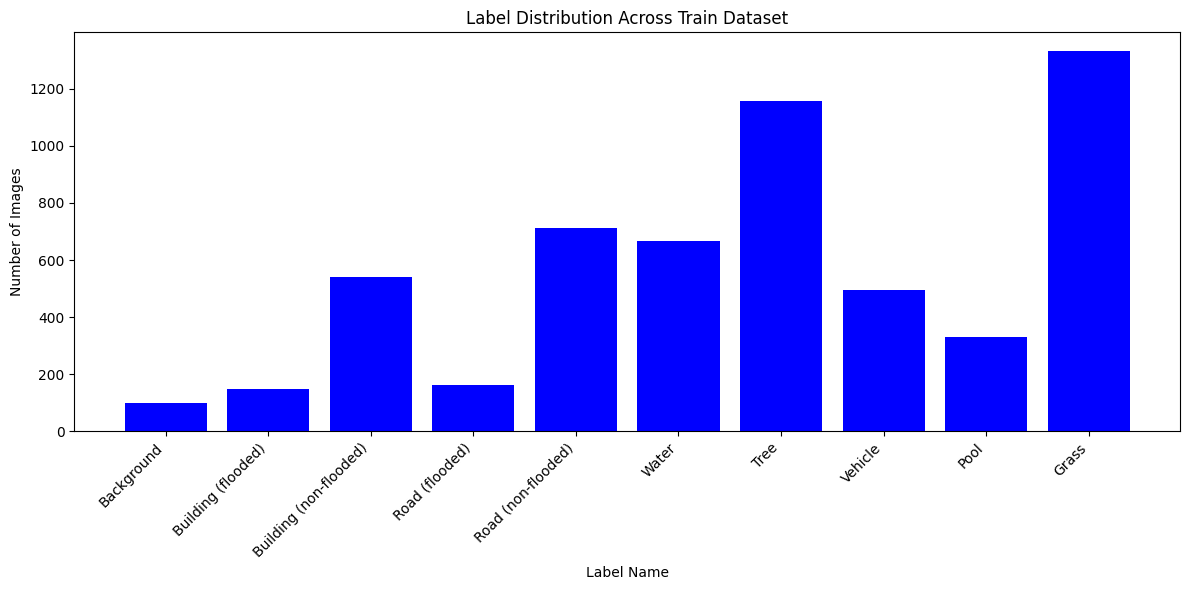

In [72]:
# Plot the distribution of labels across the dataset
plot_label_distribution(image_count_across_train_dataset, 'Label Distribution Across Train Dataset')

In [69]:
# Example usage
subsets = ['test']  
image_count_across_test_dataset = calculate_label_image_count(data_dir, subsets)
print(image_count_across_test_dataset)

100%|██████████| 448/448 [01:55<00:00,  3.88it/s]

{'Background': 40, 'Building (flooded)': 47, 'Building (non-flooded)': 173, 'Road (flooded)': 49, 'Road (non-flooded)': 234, 'Water': 183, 'Tree': 364, 'Vehicle': 166, 'Pool': 96, 'Grass': 414}


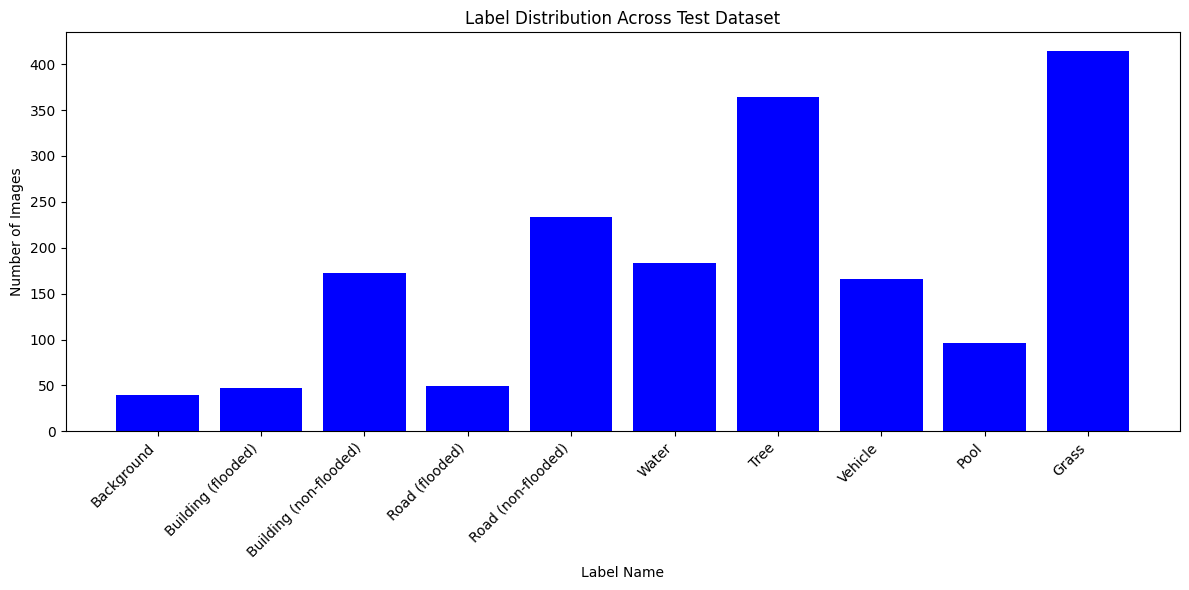

In [70]:
# Plot the distribution of labels across the dataset
plot_label_distribution(image_count_across_test_dataset, 'Label Distribution Across Test Dataset')

In [75]:
import numpy as np
import os
from imageio import imread
from tqdm import tqdm

def calculate_label_image_count_with_filter(base_dir, subsets, filter_labels):
    """
    Calculate the number of images each label appears in across specified subsets of a dataset.

    Args:
    base_dir (str): The base directory where the dataset is stored.
    subsets (list): A list of subsets of the dataset to analyze ('train', 'test', 'val').

    Returns:
    dict: A dictionary with class names as keys and the number of images they appear in as values.
    """
    label_names = {
        0: 'Background', 1: 'Building (flooded)', 2: 'Building (non-flooded)',
        3: 'Road (flooded)', 4: 'Road (non-flooded)', 5: 'Water', 6: 'Tree',
        7: 'Vehicle', 8: 'Pool'
    }

    # Initialize dictionary to count image appearances for each label across all subsets
    label_image_count = {name: 0 for name in label_names.values()}

    # Process each subset and count labels
    for subset in subsets:
        masks_dir = os.path.join(base_dir, subset, f'{subset}-label-img')
        
        # Track labels found in each image to avoid double counting for the same image
        for filename in tqdm(os.listdir(masks_dir)):
            if filename.endswith('.png'):
                filepath = os.path.join(masks_dir, filename)
                mask = imread(filepath)
                unique_labels = np.unique(mask)

                #if image contains any of the filter labels, skip it
                if any(label in filter_labels for label in unique_labels):
                    continue
                
                # Update image count for each unique label found in this mask
                for label in unique_labels:
                    if label in label_names:
                        label_image_count[label_names[label]] += 1

    return label_image_count

# Example usage
subsets = ['train']  
image_count_across_train_dataset_without_grass_contained_images = calculate_label_image_count_with_filter(data_dir, subsets, filter_labels=[9])
print(image_count_across_train_dataset_without_grass_contained_images)

  0%|          | 0/1445 [00:00<?, ?it/s]

100%|██████████| 1445/1445 [05:57<00:00,  4.04it/s]

{'Background': 30, 'Building (flooded)': 58, 'Building (non-flooded)': 44, 'Road (flooded)': 60, 'Road (non-flooded)': 32, 'Water': 98, 'Tree': 102, 'Vehicle': 71, 'Pool': 54}


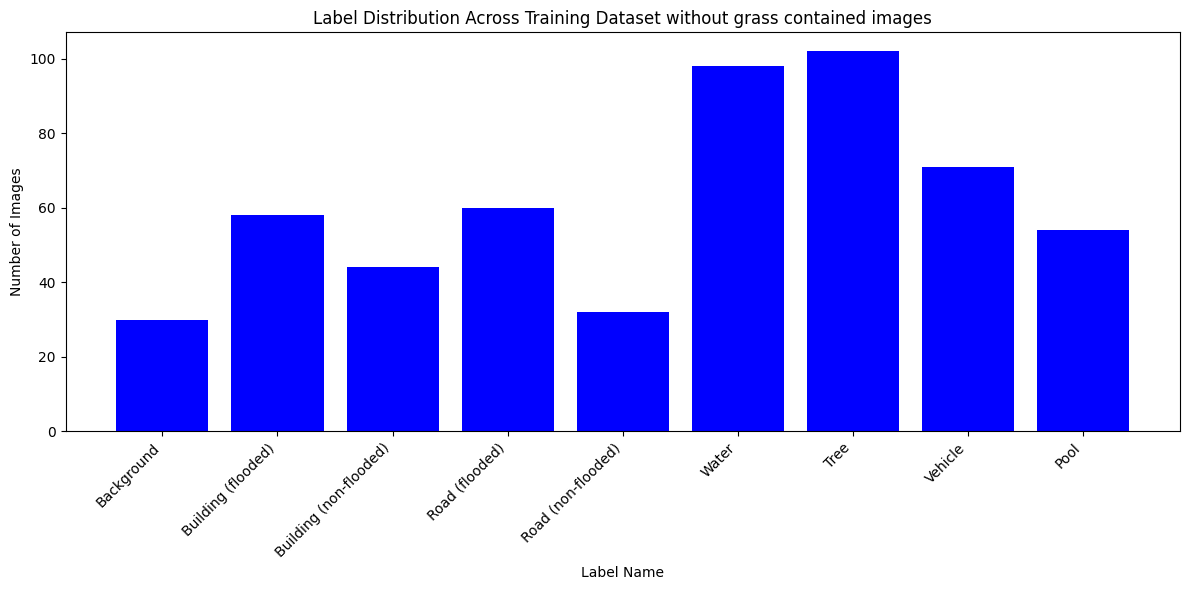

In [76]:
# Plot the distribution of labels across the dataset
plot_label_distribution(image_count_across_train_dataset_without_grass_contained_images, 'Label Distribution Across Training Dataset without grass contained images')